# CPSC 330 hw3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

## Exercise 1: implementing `DummyClassifier`
rubric={points:20}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.
    
    This implementation only works when y only contains 0s and 1s.
    """
    
    
    def fit(self, X, y):
        # adapted from https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
        unique, counts = np.unique(y, return_counts=True)
        vals = dict(zip(unique, counts))
        self.neg = vals[0]/len(y)
        self.pos = vals[1]/len(y)
        if self.neg < self.pos:
            self.dummy = 1
        else:
            self.dummy = 0               
        return None
    
        
    def predict(self, X):
        # adapted from https://stackoverflow.com/questions/5891410/numpy-array-initialization-fill-with-identical-values
        return np.full(len(X),self.dummy) 

    
    def predict_proba(self, X):
        pos = np.full(len(X),self.pos)
        neg = np.full(len(X),self.neg)
        proba = np.column_stack((neg,pos))
        return proba
    
    
    def score(self, X, y):
        y_pred = self.predict(X)
        compare = np.column_stack((y,y_pred))
        mask = ((compare[:,0]) == (compare[:,1]))
        return len(compare[mask])/len(y)


Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy);
sk_dc.fit(X_train_dummy, y_train_dummy);
      
assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy))
assert np.allclose(my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy))

Below are some tests for `score`.

In [5]:
assert np.isclose(my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy))
assert np.isclose(my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy))

## Exercise 2: Trump Tweets

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not commit it to your repos. This assignment hopefully shipped with a `.gitignore` file that will prevent you from committing the dataset to your repo.

In [6]:
tweets_df = pd.read_csv('realdonaldtrump.csv', index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:6}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# Avoids violating the golden rule by splitting the features (X) and target (y) into train/test sets (X_train, X_test, y_train, y_test), using a fixed random shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Creates an unfit CountVectorizer object with a predifined list of 'stop_words' (common english words that will be ignored by CountVectorizer when deciding the vocabulary because they lack useful info)
countvec = CountVectorizer(stop_words='english')

# Creates a unfit logististicRegression object that can be used to fit/predict/score on data with a max of 1000 iterations for the model to converge at optimal weights
lr = LogisticRegression(max_iter=1000)

# Creates a data pipeline with the CountVectorizer and LogisticRegression objects created earlier; which, ONLY WHEN fit, will first fit/transform values with 'countvec', then fit the 'logreg' model
pipe = Pipeline([('countvec', countvec), ('logreg', lr)])

# Computes 5-fold validation scores except following both steps of the pipeline for each fold, and presents the results including the training score
cross_val_results = pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

# Returns the mean validation score across all 5 folds of cross-validation
cross_val_results.mean()

fit_time       1.730353
score_time     0.153433
test_score     0.897890
train_score    0.967045
dtype: float64

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: sklearn calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cilantro dataset? How does this relate to the different sub-scores from the 5 folds?

In [11]:
print(cross_val_results['test_score'])
print(f"Standard deviation of test scores: {np.std(cross_val_results['test_score'])}")

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64
Standard deviation of test scores: 0.0014725591589632206


**Answer:** Given the standard deviation above, I believe the 5 validation scores are fairly close, becuase they are on average less than a percentage point away from the mean. This dataset has 43352 total rows compared to the cilantro dataset's 200 (the training data is roughly 75% of this). Because this dataset has significanly more rows, its sub-score validation accuracy is likely to vary less (closer together), as big variances in the distribution become less pronounced. It is like the law of large numbers: as sample size grows, the mean gets closer to the average of the whole population [1]. As the number of data points in each fold increases, the sub-score specific to that fold gets closer to the average validation score.

[1] https://www.investopedia.com/terms/l/lawoflargenumbers.asp

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train)
cv_scores = pd.DataFrame(cross_validate(dc, X_train, y_train, cv=5, return_train_score=True))
print(cv_scores)
print(f"Average validation score: {np.mean(cv_scores['test_score'])}")

   fit_time  score_time  test_score  train_score
0  0.000000         0.0    0.738582     0.738534
1  0.015607         0.0    0.738582     0.738534
2  0.000000         0.0    0.738582     0.738534
3  0.000000         0.0    0.738428     0.738572
4  0.000000         0.0    0.738542     0.738544
Average validation score: 0.7385433966473036


**Answer:** Logistic Regression achieves a 5-fold validation score of around 0.90 while Dummy Classifier achieves a 5-fold validation score of around 0.74. Therefore, it seems logistic regression is useful because it performs significanlty better on data it has not seen before (the validation data in each fold). Using `CountVectorizer` is unnecessary, because it is only used to obtain our feature columns, but `DummyClassifier` only looks at the target column.

#### 2(d) probability scores
rubric={points:3}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 4".

In [14]:
# From Lecture 4
proba = pipe.predict_proba(X_test)
viral_tweet_idx = np.argmax(proba[:,1]);
print(f"Index of tweet in the test set with highest predicted probability of being viral: {viral_tweet_idx}\n")
print("Tweet in the test set with the highest predicted probability of being viral:")
print(str(X_test.iloc[viral_tweet_idx]))
print(f"\nAssociated probability score: {proba[viral_tweet_idx][1]}")

Index of tweet in the test set with highest predicted probability of being viral: 5134

Tweet in the test set with the highest predicted probability of being viral:
Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!

Associated probability score: 0.99999993252877


#### 2(e) coefficients
rubric={points:3}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `Pipeline` object as follows:


In [15]:
vec_from_pipe = pipe.named_steps['countvec']
lr_from_pipe  = pipe.named_steps['logreg']

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [16]:
# From Lecture 4
vocab = vec_from_pipe.get_feature_names()
weights = lr_from_pipe.coef_.ravel()
words_weights_df = pd.DataFrame(data=weights, index=vocab, columns=['Weight'])
words_weights_df = words_weights_df.sort_values(by="Weight", ascending=False)
print("5 words with the highest coefficients (weights):")
print(words_weights_df[0:5])
print("\n5 words with the lowest coefficients (weights):")
print(words_weights_df.iloc[[-1,-2,-3,-4,-5]])

5 words with the highest coefficients (weights):
               Weight
harassment   2.731773
mini         2.712408
fake         2.692772
coronavirus  2.434191
transcripts  2.380542

5 words with the lowest coefficients (weights):
                   Weight
realdonaldtrump -3.116883
trump2016pic    -2.637304
barackobama     -2.565433
trump2016       -2.316150
1pic            -2.295131


#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `Pipeline`s and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [17]:
countvec = CountVectorizer(stop_words='english')
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [18]:
train_amt = int(len(X_train)*0.8)

X_train_fold_raw = X_train[:train_amt]
X_valid_fold_raw = X_train[train_amt:]
y_train_fold = y_train[:train_amt]
y_valid_fold = y_train[train_amt:]

X_train_fold = countvec.fit_transform(X_train_fold_raw)
X_valid_fold = countvec.transform(X_valid_fold_raw)

lr.fit(X_train_fold, y_train_fold)
score = lr.score(X_valid_fold, y_valid_fold)

print(f"Logistic Regression validation score on one fold: {score}")

Logistic Regression validation score on one fold: 0.8966630785791173


## Exercise 3: hyperparameter optimization

#### 3(a)
rubric={points:2}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

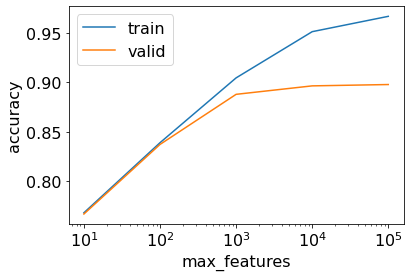

In [19]:
train_scores = []
cv_scores = []

max_features = [10,100,1000,10_000,100_000]

for mf in max_features:
#    print(mf)
    pipe = Pipeline([('countvec', CountVectorizer(stop_words='english', max_features=mf)), 
                         ('logreg', LogisticRegression(max_iter=1000))])
    cv_results = cross_validate(pipe, X_train, y_train,  return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend();
plt.xlabel("max_features");
plt.ylabel("accuracy");

In [20]:
pd.DataFrame({"max_features" : max_features, "train" : train_scores, "cv" : cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904633,0.887956
3,10000,0.951498,0.896537
4,100000,0.967045,0.897890


In [21]:
best_max_features = max_features[np.argmax(cv_scores)]
print(f"The best value of max_features is {best_max_features} because it maximizes the cross-validation score at {np.max(cv_scores)}")

The best value of max_features is 100000 because it maximizes the cross-validation score at 0.8978900824847041


#### 3(b)
rubric={points:2}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

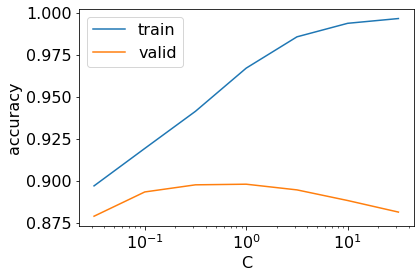

In [22]:
train_scores = []
cv_scores = []

C_vals = 10.0**np.arange(-1.5,2,0.5)

for C in C_vals:
#    print(C)
    pipe = Pipeline([('countvec', CountVectorizer(stop_words='english', max_features=None)), 
                         ('logreg', LogisticRegression(max_iter=1000, C=C))])
    cv_results = cross_validate(pipe, X_train, y_train,  return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())
    
plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend();
plt.xlabel("C");
plt.ylabel("accuracy");

In [23]:
pd.DataFrame({"C" : C_vals, "train" : train_scores, "cv" : cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985675,0.894507
5,10.000000,0.993733,0.888171
6,31.622777,0.996571,0.881282


In [24]:
best_C = C_vals[np.argmax(cv_scores)]
print(f"The best value of C is {best_C} because it maximizes the cross-validation score at {np.max(cv_scores)}")

The best value of C is 1.0 because it maximizes the cross-validation score at 0.8978900824847041


#### 3(c)
rubric={points:10}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [25]:
# From Lecture 5
countvec = CountVectorizer(stop_words='english')
lr = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ('countvec', countvec),
    ('lr', lr)])

param_grid = {
    "countvec__max_features": [10,100,1000,10_000,100_000],
    "lr__C": 10.0**np.arange(-1.5,2,0.5)
}

grid_search = GridSearchCV(pipe, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train);
best = grid_search.best_params_
print(f"According to Grid Search:\nThe best value of max_features is {best['countvec__max_features']}\nThe best value of C is {best['lr__C']}")

if best['countvec__max_features'] == best_max_features:
    print(f"\nThe best max_features found agrees with part (a): {best_max_features}")
else:
    print(f"\nThe best max_features found: {best['countvec__max_features']} differs from part (a): {best_max_features}")

if best['lr__C'] == best_C:
    print(f"The best C found agrees with part (a): {best_C}")
else:
    print(f"The best C found: {best['lr__C']} differs from part (a): {best_C}")

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   43.6s finished


According to Grid Search:
The best value of max_features is 100000
The best value of C is 1.0

The best max_features found agrees with part (a): 100000
The best C found agrees with part (a): 1.0


**Answer:** It makes sense for these values to agree with each other, but in general, it is possible for the values to disagree as well. If there is some relation between the hyperparamaters, optimizing them together (each possible combination) could yeild a different result than optimizing one while holding the other constant.

#### 3(d)
rubric={points:3}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [26]:
# From Lecture 5
print("Validation scores from Grid Search:")
cv_scores = pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'param_countvec__max_features', 'param_lr__C', 'rank_test_score']].set_index("rank_test_score").sort_index()
cv_scores.head()

Validation scores from Grid Search:


,mean_test_score,param_countvec__max_features,param_lr__C
rank_test_score,,,
1,0.897890,100000,1
2,0.897521,100000,0.316228
3,0.897029,10000,0.316228
4,0.896537,10000,1
5,0.894507,100000,3.16228


In [27]:
test_score = grid_search.score(X_test, y_test)
validation_score = cv_scores.loc[1,'mean_test_score']
print(f"The test score was: {test_score}, while the validation score was: {validation_score}")

The test score was: 0.8992434028418528, while the validation score was: 0.8978900824847041


**Answer:** The test and validation accuracy are fairly similar. In fact, the validation accuracy is actually lower than the test accuracy. I think we can attribute this to the random shuffling of train/test values. The closeness between test and validation accuracy increases my trust in the model.

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

**Answers:**

1. We might have a different # of columns (unless we set a max_features) / different vocabulary features between train and test data - thus jumbling up what each feature column actually represents and messing up the model. Python might return an error if there is a mismatch in the # of columns between the train/test data, or even worse will not display an error if the number of columns are the same, but the features are different.
2. The Golden Rule says that a test set should only be used 'once' (Lecture 4) so as to not influence the training data in any way because it must be as close to a proxy of deployment data as possible (unseen).  Violation will not necessarily give a worse classifier (on test data), but might instead lead to a misleadingly optimistic test score that diverges further from the deployment score because the model was indirectly trained/affected by test data (a worse classifier on deployment).
3. Assuming we have access to to the `classes_` field of the linear regression to interpret `predict_proba()`, `predict_proba()` would be more useful. While `predict` only returns the class with the higher probability, `predict_proba` provides the probabilities associated with each class, meaning it is easy to obtain the results of `predict`, but we get a more nuanced picture of which examples our model is more/less confident in predicting.
4. Pipelines help avoid mistakes like violating the Golden Rule, refitting on the test split, while automatically making sure the same transformations take place on the train/test set. Moreover, they simplify and reduce human coding error in a model that may require many preprocessing steps and transformations, by providing a simple object to use for cross validation, fitting using `X_train`, and scoring using `X_test`.
5. `RandomizedSearchCV` is advantageous because you can provide less restriction on which values to try, while choosing the number of runs. Additionally, it tends to be better in finding optimal values where variation in some hypterparameters are less important than others (more parameters do not affect effeciency) (Lecture 5).

## Submission to Canvas

When you are ready to submit your assignment do the following:


1. **NEW STEP**: if you run `pip install canvasutils -U` in your terminal with your environment activated, you should update to a newer version of `canvasutils`. This new version should address a couple pain points:
  - The dropdown menu should now be sorted from most to least recent, meaning the default will be hw3.
  - For those having trouble with the Jupyter widgets and the dropdowns: if you add the argument `no_widgets=True` to your `submit` call, it should let you do a text-based entry of your key and avoid the dropdowns altogether.
1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below **or** by `File -> Export Notebook As... -> Export Notebook to HTML`.
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
>For this step, you will need a Canvas *Access Token* token. If you haven't already got one, log-in to Canvas, click `Account` (top-left of the screen), then `Settings`, then scroll down until you see the `+ New Access Token` button. Click that button, give your token any name you like and set the expiry date to Dec 31, 2020. Then click `Generate token`. Save this token in a safe place on your computer as you'll need it for all assignments. Treat the token with as much care as you would an important password. 

In [28]:
from canvasutils.submit import submit, convert_notebook

# Note: the canvasutils package should have been installed as part of your environment setup - 
# see https://github.com/UBC-CS/cpsc330/blob/master/docs/setup.md

In [29]:
# convert_notebook("hw3.ipynb", "html")  # uncomment and run when you want to try convert your notebook to HTML (or you can convert manually from the File menu)

In [30]:
# submit(course_code=53561, token=False)  # uncomment and run when ready to submit 